# Metropolis Hastings

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

## Observations

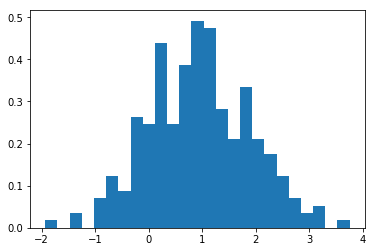

In [2]:
num_observations = 250
theta_true = 1.


N = torch.distributions.normal.Normal(theta_true, 1.)
observations = N.sample(torch.Size([num_observations])).view(-1).numpy()

plt.hist(observations, bins=25, density=True)
plt.show()

## Posterior inference with Metropolis-Hastings

In [3]:
def log_likelihood(theta, observations):
    with torch.no_grad():
        N = torch.distributions.normal.Normal(theta.item(), 1.)
        likelihood = N.log_prob(observations).sum()
        
    return likelihood

In [4]:
from hypothesis.transition import UniformTransitionDistribution

min = torch.tensor(-5)
max = torch.tensor(8)
transition = UniformTransitionDistribution(min, max)

In [5]:
from hypothesis.inference import MetropolisHastings

sampler = MetropolisHastings(log_likelihood, transition)

In [6]:
theta_0 = torch.tensor(5).float()
result = sampler.infer(
    observations,
    theta_0=theta_0,
    samples=100000,
    burnin_steps=100)

In [7]:
from hypothesis.visualization.mcmc import traceplot
from hypothesis.visualization.mcmc import autocorrelation

In [8]:
def traceplot(result, **kwargs):
    # Argument key definitions.
    KEY_SHOW_BURNIN = "show_burnin"
    KEY_TRUTH = "truth"
    KEY_ASPECT = "aspect"

    # Show argument defaults.
    show_burnin = False
    truth = None
    aspect = "auto"
    # Process optional arguments.
    if KEY_SHOW_BURNIN in kwargs.keys():
        show_burnin = bool(kwargs[KEY_SHOW_BURNIN])
    if KEY_TRUTH in kwargs.keys():
        truth = kwargs[KEY_TRUTH]
        if type(truth) is not list:
            truth = [truth]
    if KEY_ASPECT in kwargs.keys():
        aspect = float(kwargs[KEY_ASPECT])
    # Start the plotting procedure.
    max_iterations = result.iterations()
    num_parameters = result.num_parameters()
    if show_burnin and result.has_burnin():
        max_iterations += result.burnin_iterations()
    x = np.arange(1, max_iterations + 1)
    fig, ax = plt.subplots(nrows=num_parameters, ncols=1)

    def plot_chain(ax, parameter_index, aspect):
        chain = []
        if show_burnin and result.has_burnin():
            chain = chain + result.burnin_chain(parameter_index)
        chain = chain + result.chain(parameter_index)
        ax.grid(True, alpha=0.4)
        ax.set_xlim([0, len(chain)])
        ax.minorticks_on()
        ax.plot(x, chain)
        aspect = (1. / ax.get_data_ratio()) * (1. / aspect)
        ax.set_aspect(aspect)
        if not parameter_index:
            parameter_index = 0
        ax.axhline(truth[parameter_index], c='r', lw=2, linestyle='--', alpha=.7)

    if num_parameters > 1:
        for parameter_index, row in enumerate(ax):
            plot_chain(row, parameter_index, aspect)
    else:
        plot_chain(ax, None, aspect)

    return fig, ax

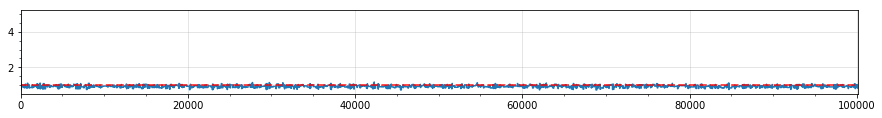

In [9]:
fig, axes = traceplot(result, truth=theta_true, aspect=10, show_burnin=True)
fig.set_figheight(15)
fig.set_figwidth(15)
plt.show()